# GCN for Text Classification
PyTorch reimplementation of **Graph Convolutional Networks for Text Classification (AAAI 2019)**

# Table of Content
* [Preamble](#Preamble)
* [Data preparation](#Data-preparation)
    * [Load raw data](#Load-raw-data)
    * [Train-test split](#Train-test-split)
    * [Setup vocabulary utils](#Setup-vocabulary-utils)
    * [Setup statistics utils](#Setup-statistics-utils)
    * [Build Text graph](#Build-Text-graph)
* [PyTorch Dataset class](#PyTorch-Dataset-class)
* [TextGCN Module](#TextGCN-Module)
* [Training](#Training)
    * [Prepare text graphs](#Prepare-text-graphs)
    * [Training configs](#Training-configs)
    * [Verify training accuracy](#Verify-training-accuracy)

# Preamble

In [1]:
# Preamble
import time, random
import re, string
import os, sys
import math
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CPU = torch.device("cpu")
WINDOW_SIZE = 20
EMBEDDING_SIZE = 200
NUM_CLASSES = 52
DROPOUT = 0.5

# Data preparation
The word embeddings is trained on YELP-review dataset: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset

## Load raw data

In [2]:
# # YELP Preparation
# data_file = open("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json")
# data = []

# # cnt = 1569264 # Size of YELP 2015 dataset
# cnt = 100000

# for line in data_file:
#     data.append(json.loads(line))
#     cnt -= 1
#     if cnt == 0:
#         break
    
# data_file.close()
# df = pd.DataFrame(data)

# print("Number of datapoints:", len(df))
# df.head()

# # R52 Preparation
# train_ds = pd.read_csv('/kaggle/input/smolcsv/r52-train-stemmed.csv')
# val_ds = pd.read_csv('/kaggle/input/smolcsv/r52-dev-stemmed.csv')
# test_ds = pd.read_csv('/kaggle/input/smolcsv/r52-test-stemmed.csv')

# ds = pd.concat([train_ds, val_ds, test_ds])

# print('Size of data corpus:', len(ds))
# ds.head()

# MR Preparation
odf = pd.read_csv('/kaggle/input/smolcsv/MR.csv')

print("Number of datapoints:", len(odf))
odf.head()

Number of datapoints: 10662


,Unnamed: 0,text,Sentiment,label
0,0,the rock is destined to be the 21st century's ...,positive,1
1,1,"the gorgeously elaborate continuation of "" the...",positive,1
2,2,effective but too-tepid biopic,positive,1
3,3,if you sometimes like to go to the movies to h...,positive,1
4,4,"emerges as something rare , an issue movie tha...",positive,1


## Train-test split
Only trainset is needed for building pretrained **TextGCN**.

In [3]:
# MR preparation
df_size = len(odf)
idx = [x for x in range(df_size)]
random.Random(555).shuffle(idx)

train_num = int(df_size * 0.8)
val_num = int(df_size * 0.1)
test_num = int(df_size * 0.1)

# print(train_num, val_num, test_num)

train_idx = idx[:train_num]
val_idx = idx[train_num : (train_num + val_num)]
test_idx = idx[(train_num + val_num) : ]

train_df = odf.iloc[train_idx].reset_index()
val_df = odf.iloc[val_idx].reset_index()
test_df = odf.iloc[test_idx].reset_index()

# train_df = pd.read_csv('/kaggle/input/smolcsv/r52-train-stemmed.csv')
# val_df = pd.read_csv('/kaggle/input/smolcsv/r52-dev-stemmed.csv')
# test_df = pd.read_csv('/kaggle/input/smolcsv/r52-test-stemmed.csv')

print('Size of trainset:', len(train_df))
print('Size of valset:', len(val_df))
print('Size of testset:', len(test_df))

df = pd.concat([train_df, val_df, test_df])

Size of trainset: 8529
Size of valset: 1066
Size of testset: 1067


## Setup vocabulary utils
Here the frequency counter, vocab object and tokenizer is defined.

Reference: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html and https://github.com/usydnlp/TextGCN_analysis/blob/main/final.ipynb

In [4]:
# Text preprocessing
from nltk.corpus import stopwords
import nltk
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def clean_str(string, vocab_wordlist):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.strip().lower()
    
    # Remove stop words
#     words = string.split()
#     new_words = []
#     for word in words:
#         if word not in stop_words and word in vocab_wordlist.keys() and vocab_wordlist[word] >= 5:
#             new_words.append(word)
            
#     return ' '.join(new_words)

    return string

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Set up Vocab
# Source: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab, build_vocab_from_iterator

from collections import Counter

tokenizer = get_tokenizer("basic_english")

def get_counter(texts):
    counter = Counter()
    for text in texts:
        counter.update(tokenizer(text))
    return counter

def get_vocab(texts, unk= False):
    counter = get_counter(texts)
    if unk:
        vocabulary = vocab(
            counter,
            specials= ["<unk>"],
            min_freq= 1
        )
        vocabulary.set_default_index(vocabulary["<unk>"])
    else:
        vocabulary = vocab(
        counter,
        min_freq= 1
    )
    return vocabulary

def text_pipeline(text, vocabulary):
    return vocabulary(tokenizer(text))

In [6]:
# Clean data
corpus = []
for i in range(len(train_df)):
    corpus.append(train_df.iloc[i]['text'])
for i in range(len(val_df)):
    corpus.append(val_df.iloc[i]['text'])
for i in range(len(test_df)):
    corpus.append(test_df.iloc[i]['text'])
    
pre_wordlist = get_counter(corpus)

for i in range(len(train_df)):
    s = train_df.iloc[i]['text']
    train_df.at[i, 'text'] = clean_str(s, pre_wordlist)
for i in range(len(val_df)):
    s = val_df.iloc[i]['text']
    val_df.at[i, 'text'] = clean_str(s, pre_wordlist)
for i in range(len(test_df)):
    s = test_df.iloc[i]['text']
    test_df.at[i, 'text'] = clean_str(s, pre_wordlist)
    
df = pd.concat([train_df, val_df, test_df])

print('Size of data corpus:', len(df))

Size of data corpus: 10662


## Setup statistics utils
Here the statistics metrics $TF-IDF$ and $PMI$ are defined. Words in Vocab are indexed from $1\dots N$ and documents are indexed from $1\dots V$

In [7]:
import scipy.sparse as sp # Sparse matrix utilities
from collections import defaultdict 

In [8]:
from scipy.sparse import coo_matrix

# Sparse matrix utils
def build_sparse(W_dict, shape):
    W_row, W_col, W_data = [], [], []
    for (current, nxt) in W_dict.keys():
        W_row.append(current)
        W_col.append(nxt)
        W_data.append(W_dict[(current, nxt)])
        
    return sp.csr_matrix((W_data, (W_row, W_col)), shape= shape)

def ret_zero():
    return 0

def csr2spMat(X_csr):
    '''
    Consult: https://stackoverflow.com/questions/50665141/converting-a-scipy-coo-matrix-to-pytorch-sparse-tensor
    '''
    X_coo = sp.csr_matrix.tocoo(X_csr, copy= True)
    
    values = X_coo.data
    indices = np.vstack((X_coo.row, X_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = X_coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to(DEVICE)

In [9]:
# Statistics
def get_W(texts, window_size):
    '''
    Get the number of windows over texts.
    <texts> is expected to have type of list(torch.Tensor)
    
    Batch_size: B = len(texts)
    '''
    res = 0
    for text in texts:
        res += max(len(text) - window_size + 1, 1)
    return res


def build_W(texts, vocabulary, window_size, check= False):
    '''
    Build the co-occurence matrix W which will be represented using csr_matrix((data, (row_ind, col_ind))
    <texts> is expected to have type of list(torch.Tensor)
    <vocab> is the Vocabulary built over text
    
    Batch size: B = len(texts)
    Vocab size: V = len(vocabulary)
    Number of Node: N = B + V
    
    Output:
    -----
    W_dict (defaultdict) : Edge-list for construction of W
    W (sp.csr_matrix): Co-occurence matrix. Shape = (V, V)
    mW (np.ndarray): Occurence vector. Can be viewed as marginallized W. Shape = (V)
    '''
    B = len(texts)
    V = len(vocabulary)
    N = B + V
    mW = np.zeros((V)) # Margin W - Occurence vector
    
    W_dict = defaultdict(ret_zero) 
    
    if check:
        print('*********************************')
        print('Tokenized texts:')
    for text in texts:
        L = len(text)
        if check:
            print(text)
        for i in range(max(L - window_size + 1, 1)):
            master_range = text[i : min(i + window_size, L)]
            mW[np.unique(master_range)] += 1
            for j in range(window_size):
                if i + j >= L:
                    break
                current = text[i+j]
                W_dict[(current, current)] = W_dict[(current, current)] + 1
                for nxt in master_range:
                    if current != nxt:
                        W_dict[(current, nxt)] = W_dict[(current, nxt)] + 1
                    
    W = build_sparse(W_dict, shape= (V, V))

    return W_dict, W, mW

def calc_pmi(texts, vocabulary, window_size):
    '''
    Calculate PMI
    <texts> is expected to have type of list(torch.Tensor)
    <vocab> is the Vocabulary built over text
    
    Vocab size: V
    Text length: L
    Batch size: B
    
    Output:
    -----
    pmi_dict (defaultdict) : Edge-list for construction of pmi
    pmi (sp.csr_matrix): Pairwise PMI matrix. Shape = (V, V)
    '''
    # Preparations
    nW = get_W(texts, window_size) # Number of windows
    W_dict, W, mW = build_W(texts, vocabulary, window_size) # W_ij. Shape: (V, V)
    
    V = len(vocabulary)
    pmi_dict = defaultdict(ret_zero)
    margin_p = (mW / nW)
    
    # Constructing PMI edge list.
    for (i, j) in W_dict.keys():
        if i == j:
            continue
        pij = 1.0 * W_dict[(i, j)] / nW
        pi = margin_p[i]
        pj = margin_p[j]
        
        prelog = 1.0 * pij / (pi * pj)
        if prelog <= 1.0:
            continue
        pmi_dict[(i, j)] = math.log(prelog)
        
    pmi = build_sparse(pmi_dict, shape= (V, V))
    
    return pmi_dict, pmi
    

def calc_tf_idf(texts, vocabulary):
    '''
    Calculate TF-IDFs
    <texts> is expected to have type of list(torch.Tensor)
    <vocab> is the Vocabulary built over text
    
    Vocab size: V
    Text length: L
    Batch size: B
    
    NOTES:  For text graph constructions, words will be indexed from 0 to V-1 
            while documents will be indexed from V to V + D - 1 
    '''
    V = len(vocabulary)
    B = len(texts)
    
    tf_dict = defaultdict(ret_zero) # Term frequency - Shape: (B, V)
    idf_dict = defaultdict(ret_zero) # Inverse document frequency - Shape: (V,)
    tf_idf_dict = defaultdict(ret_zero) # TF - IDF - Shape: (B, V)
    
    idf = np.zeros((V)) # No. of documents containing token. The array is 0-based instead of V-based
    
    # Term frequency
    for i, text in enumerate(texts):
#         max_freq = 0
        L = text.shape[0]
        for j in range(text.shape[0]):
            tf_dict[(V + i, int(text[j]))] += 1
#             max_freq = max(max_freq, tf_dict[(V + i, text[j])])
            
            idf_dict[(V + i, int(text[j]))] = 1
        # Normalize term frequency
        for j in set(text.tolist()):
            tf_dict[(V + i, j)] =  1.0 * tf_dict[(V + i, j)] / L
    
    # Inverse document frequency
    for (i, j) in idf_dict.keys():
#         print(i, j)
        idf[j] += idf_dict[(i, j)]
        
#     idf[0] = B # There is no unknown token. Hence, idf[<unk>] = 0
    idf = np.log(1.0 * B / idf) # Shape: (V,)
    
    # TF - IDF
    for (i, j) in tf_dict.keys():
        tf_idf_dict[(i, j)] = 1.0 * tf_dict[(i, j)] * idf[j]
        tf_idf_dict[(j, i)] = 1.0 * tf_dict[(i, j)] * idf[j]

    tf = build_sparse(tf_dict, shape= (B + V, V))
    tf_idf = build_sparse(tf_idf_dict, shape= (B + V, V + B))
    
    return tf_dict, tf, idf, tf_idf_dict, tf_idf

In [10]:
# Pipeline testing
raw_texts = ['A two-layer GCN can allow message', 
             'A two-layer GCN can allow message', 
             'A two-layer GCN can allow message',
             'A two-layer GCN can allow message',
             'A two-layer GCN can allow message',
             'Thus although there is no direct document-document edges in the graph',
             'Thus although there is no direct document-document edges in the graph',
             'Thus although there is no direct document-document edges in the graph',
             'Thus although there is no direct document-document edges in the graph',
             'Thus although there is no direct document-document edges in the graph',
             'In our preliminary experiment',
             'In our preliminary experiment',
             'In our preliminary experiment',
             'In our preliminary experiment',
             'In our preliminary experiment']
vocabulary = get_vocab(raw_texts)
print('*********************************')
print('Token list:')
print(vocabulary.get_itos())
print('*********************************')
texts = []
for text in raw_texts:
    texts.append(text_pipeline(text, vocabulary))
    
print('TEXTS:')
print(texts)
    
print('*********************************')
print('Vocabulary size V = ', len(vocabulary))
_, W, mW = build_W(texts, vocabulary, WINDOW_SIZE, True)
print('*********************************')
print('Shape of W:', W.shape, 'Number of stored values:', W.nnz)
print('Shape of mW:', mW.shape)
print('*********************************')
print('Co-occurence matrix W:')
print(W)
print('*********************************')
print('Margin-W:')
print(mW)
print('*********************************')
print('PMI:')
_, pmi = calc_pmi(texts, vocabulary, WINDOW_SIZE)
print('Shape of PMI', pmi.shape, 'Number of stored values:', pmi.nnz)
print(pmi)
print('*********************************')
print('TF-IDF:')
texts = [torch.Tensor(text) for text in texts]
_,_,_,_, tf_idf = calc_tf_idf(texts, vocabulary)
print('Shape of TF-IDF', tf_idf.shape, 'Number of stored values:', tf_idf.nnz)
print(tf_idf)

*********************************
Token list:
['a', 'two-layer', 'gcn', 'can', 'allow', 'message', 'thus', 'although', 'there', 'is', 'no', 'direct', 'document-document', 'edges', 'in', 'the', 'graph', 'our', 'preliminary', 'experiment']
*********************************
TEXTS:
[[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [14, 17, 18, 19], [14, 17, 18, 19], [14, 17, 18, 19], [14, 17, 18, 19], [14, 17, 18, 19]]
*********************************
Vocabulary size V =  20
*********************************
Tokenized texts:
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[6, 7, 8, 9, 10, 11, 12, 13, 14, 1

## Build Text graph
The adjacency matrix $A$ is designed as follow:

\begin{equation}
A = \begin{pmatrix}
PMI & TF-IDF\\
TF-IDF & 0
\end{pmatrix}
\end{equation}

In [11]:
def build_A(texts, vocabulary, window_size, nNodes):
    '''
    Calculate adjacency matrix A with shape (V+B, V+B)
    <texts> is expected to have type of list(torch.Tensor)
    <vocab> is the Vocabulary built over text
    
    Vocab size: V
    Text length: L
    Batch size: B
    Nodes: N = B + V
    
    '''
    _, _, _, tf_idf_dict, _ = calc_tf_idf(texts, vocabulary)
    pmi_dict, _ = calc_pmi(texts, vocabulary, window_size)
    
    B = len(texts)
    V = len(vocabulary)
    
    N = B + V # Number of nodes
    
    A_dict = defaultdict(ret_zero) # Adjacency matrix. Shape: (N, N)
    
    # Word-word edges, obtained by pmi_dict
    for x in pmi_dict.keys():
        A_dict[x] = pmi_dict[x]
        
    # Document-word edges, obtained by tf_idf_dict
    for x in tf_idf_dict.keys():
#         assert x[0] >= V and x[1] < V # Ensure edge (i, j) has i as document index, and j as token index
        A_dict[x] = tf_idf_dict[x]
    
    if nNodes is None:
        for i in range(N):
            A_dict[(i, i)] = 1
        A = build_sparse(A_dict, shape= (N, N))
    else:
        for i in range(nNodes):
            A_dict[(i, i)] = 1
        A = build_sparse(A_dict, shape= (nNodes, nNodes))
    
    return A_dict, A

def build_graph(texts, vocabulary, window_size, nNodes= None):
    '''
    Build A_tilde = D x A x D
    
    Nodes: N
    '''
    B = len(texts)
    V = len(vocabulary)
    
    N = B + V # Number of nodes
    
    A_dict, A = build_A(texts, vocabulary, window_size, nNodes= nNodes)
    
    D_dict = defaultdict(ret_zero)
    
    for (i, j) in A_dict.keys():
        D_dict[(i, i)] = D_dict[(i, i)] + 1
    
    if nNodes is None:
        for i in range(N):
            D_dict[(i, i)] = (D_dict[(i, i)] ** (-0.5))
    else:
        for i in range(nNodes):
            D_dict[(i, i)] = ((1.0 * D_dict[(i, i)]) ** (-0.5))
    
    if nNodes is None:
        D = build_sparse(D_dict, shape= (N, N)) # Degree matrix
    else:
        D = build_sparse(D_dict, shape= (nNodes, nNodes))
    G = (D * A) * D # A_tilde. Shape = (N, N)
    
    return G

def build_X(vocab, grand_vocab, batch_size, pretrained= True, W_e= None, init_dim= None):
    '''
    Construct graph feature input
    <vocab>: Vocabulary constructed by batch
    <grand_vocab>: Vocabulary created by pretrained embedding
    
    Embedding size: E
    Batch size: B
    Number of nodes: N
    
    Output:
    -----
    X (torch.Tensor, pretrained= True) : Embedded feature matrix. Shape = (N, N)
    X (sp.csr_matrix, pretrained= False): Sparse one-hot feature matrix. Shape = (V, V)
    '''
    if pretrained:
        assert W_e is not None
        
        X = []
        
        wordlist = vocab.get_itos()
        E = W_e[0].shape[0]
        B = batch_size
        
        # Convert relative vocab to grand_vocab
        grand_vocab_id = [] # Shape: (V,)
        for word in wordlist:
            grand_vocab_id.append(grand_vocab[word])
        
        # Extract pretrained embeddings
        Emb = W_e[grand_vocab_id] # Shape: (V, E)
        X.append(Emb)
        
        # Document one-hot
        Doc_Emb = torch.zeros(B, E)
        Doc_Emb[0:B, 0:B] = 1
        X.append(Doc_Emb.to(DEVICE))
        
        # Concat Word embeddings and Doc (one-hot) embeddings
        X = torch.cat(X, dim= 0) # Shape: (V + B, E)
        
        return X
    
    else:
        B = batch_size
        
        # Relative vocab is used as the main vocab in training phase. 
        # Given that no pretrained embedding is given.
        wordlist = vocab.get_itos()
        V = len(wordlist)
        
        # Number of nodes
        N = B + V
        
        X_dict = defaultdict(ret_zero) # One-hot feature matrix X
        for i in range(N):
            X_dict[(i, i)] = 1
        
        X = build_sparse(X_dict, shape= (N, N))
        
        return X
        

# PyTorch Dataset class
In this section, the `NLPDataset` class is defined with custom batch function `collate_batch`.

In [12]:
# YELP Dataset
def collate_graph(batch):
    '''
    Collate batch and building text graph
    '''
    raw_texts = []
    labels = []
    mask = []
    texts = []
    for _text, _label in batch:
        raw_texts.append(_text)
        labels.append(_label)
        
    vocabulary = get_vocab(raw_texts, unk= False)
    
    for _text in raw_texts:
        texts.append(np.array(text_pipeline(_text, vocabulary)))
        
    return texts, labels, vocabulary

class NLPDataset(Dataset):
    def __init__(self, df, df_sort= False):
        self.df = df
        if df_sort:
            self.sort_df_by_txt_len()
    
    def sort_df_by_txt_len(self):
        len_list = [-len(self.df.iloc[i]['text']) for i in range(len(self.df))]
        self.df = self.df.iloc[np.argsort(len_list)]
    
    def __len__(self):
        return len(self.df)

    def label_pipeline(self, x):
        return int(x)
    
    def __getitem__(self, idx):
        txt = self.df.iloc[idx]['text']
        
        label = self.label_pipeline(self.df.iloc[idx]['label'])
        
        return (txt, label)

In [13]:
# Dataset, Dataloader
trainset = NLPDataset(train_df)
valset = NLPDataset(val_df)
testset = NLPDataset(test_df)
fullset = NLPDataset(df)

trainloader = DataLoader(trainset, batch_size= len(trainset), 
                         shuffle= True, pin_memory= True, collate_fn= collate_graph)

valloader = DataLoader(valset, batch_size= len(valset), 
                         shuffle= True, pin_memory= True, collate_fn= collate_graph)

testloader = DataLoader(testset, batch_size= len(testset), 
                         shuffle= True, pin_memory= True, collate_fn= collate_graph)

fullloader = DataLoader(fullset, batch_size= len(fullset), 
                         shuffle= True, pin_memory= True, collate_fn= collate_graph)

for batch in fullloader:
    X, y, vocabulary = batch
    print("Shape of Texts:", len(X), len(X[0]))
    print("Shape of Labels:", len(y))
    GLOBAL_V = len(vocabulary)
    print("Length of Vocab:", len(vocabulary))
    GLOBAL_N = len(vocabulary) + len(y) # ONLY ONE BIG GRAPH IS NEEDED FOR TRAINING !
    print("Number of Nodes:", GLOBAL_N)
    break

Shape of Texts: 10662 32
Shape of Labels: 10662
Length of Vocab: 18340
Number of Nodes: 29002


# TextGCN Module

In [22]:
# TextGCN Module
class TextGCN(nn.Module):
    def __init__(self, graph_emb_size, num_classes, dropout= 0.5, X_emb_size= None, sparse= True):
        super(TextGCN, self).__init__()
        self.sparse = sparse
        self.E = graph_emb_size
        
        if not sparse:
            self.layer = nn.Sequential(
                nn.LazyLinear(self.E), # Lazy linear for flexible initial embedding
                nn.Dropout(p= dropout),
                nn.ReLU(),
            )
        else:
            assert X_emb_size is not None
            self.N = X_emb_size
            self.W0 = nn.Parameter(torch.randn(int(X_emb_size), graph_emb_size))
            torch.nn.init.xavier_uniform_(self.W0.data)
            self.b0 = nn.Parameter(torch.zeros((int(X_emb_size), graph_emb_size)))
#             torch.nn.init.xavier_uniform_(self.b0.data)
            self.afterlinear = nn.Sequential(
                nn.ReLU(),
                nn.Dropout(p= dropout)
            )
        
        self.classifier = nn.Sequential(
            nn.Linear(self.E, num_classes),
            nn.Softmax(dim= 1)
        )
    
    def forward(self, V, G, X, check_shape= False):
        '''
        <G> : Graph matrix, expected to have shape (N, N) and symetric
        <X> : Initial embedding. Expected to have shape (N, E_0)
        
        NOTES: If 'sparse' is True, G, X are given in scipy.sparse.csr_matrix format
        
        Vocab size: V
        Batch size: B
        Nodes: N = B + V
        Graph embedding size: E
        Initial embedding size: E_0
        '''
        # First layer:
        if not self.sparse:
            L1 = self.layer(torch.matmul(G, X)) # Shape: (N, E_0)
        else:
            L1 = G * X # Shape: (N, N), type = sp.csr_matrix
            L1 = csr2spMat(L1).to(DEVICE)
            L1 = torch.sparse.addmm(self.b0, L1, self.W0) # Shape: (N, E), type = dense matrix
            L1 = self.afterlinear(L1)
        
        # Classifier:
        if not self.sparse:
            logits = self.classifier(torch.matmul(G, L1)) # Shape: (N, num_classes)
        else:
            newG = csr2spMat(G).to(DEVICE)
            logits = self.classifier(torch.sparse.mm(newG, L1).to(DEVICE)).to(DEVICE) # Shape: (N, num_classes)
        
        doc_logits = logits[V:, :] # Shape: (B, num_classes)
        
        if check_shape:
            print('*********************************')
            print('Shape of L1:', L1.shape)
            print('Shape of logits:', logits.shape)
            print('Shape of doc_logits:', doc_logits.shape)
        
        return logits
    
def init_weights(m):
    '''
    Weight initialization.
    '''
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

In [23]:
# Model initialization
model = TextGCN(EMBEDDING_SIZE, NUM_CLASSES, DROPOUT, GLOBAL_N).to(DEVICE)
model.apply(init_weights)
# for name, param in model.named_parameters():
#     print(name) 
#     print(param.is_leaf)

TextGCN(
  (afterlinear): Sequential(
    (0): ReLU()
    (1): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=200, out_features=52, bias=True)
    (1): Softmax(dim=1)
  )
)

# Training

## Prepare text graphs
Generating text graphs from text corpus is a considerable computational bottleneck. Hence, the graph $G$ and input $X$ should be calculated in advance. Following the original paper, $X$ is constructed using one-hot encoding over vocabulary and documents inferred from the corpus. Hence, $X\in\mathbb{R}^{N\times N}$ where $N = B + V$, with $V$ being vocabulary size and $B$ being number of documents.

Hence, during inference time, texts must be load in a batch of size $B$ and tokenize using the training vocabulary in order to maintain dimensional consistency with pretrained **TextGCN** model.

In [16]:
# Preparing text graphs

# Train graphs
G_trainlist = []
X_trainlist = []
y_trainlist = []

for i, (texts, labels, vocabulary) in enumerate(fullloader):
    # Build graph
    G = build_graph(texts, vocabulary, WINDOW_SIZE) # Graph matrix
    N = G.shape[0] # Number of nodes
    
    print('Number of nodes: N = ', N)
    torch.save(vocabulary, 'train_vocab.pth')

    # Input features.
    # X = build_X(vocabulary, grand_vocab, len(labels), W_e= W_e) # Pretrained embedding mode. Not efficient.
    # One-hot encoding mode
    X_dict = defaultdict(ret_zero)
    for i in range(N):
        X_dict[(i, i)] = 1
    X = build_sparse(X_dict, shape= (N, N))
    y = torch.tensor(labels)
    
    G_trainlist.append(G)
    X_trainlist.append(X)
    y_trainlist.append(y)
    
    break # Only ONE BIG GRAPH is needed for training

GXy_train = (G_trainlist, X_trainlist, y_trainlist)
torch.save(GXy_train, "GXy.pth")

Number of nodes: N =  29002


In [17]:
# Train-Val-Test idx's
train_idx = list(range(0,len(train_df)))
val_idx = list(range(len(train_df), len(train_df) + len(val_df)))
test_idx = list(range(len(train_df) + len(val_df), len(df)))

In [18]:
# Load prebuilt graph if available
# GXy_train = torch.load('/kaggle/input/textgcn-exps/GXy.pth')

## Training configs

In [24]:
# Training configs
LR = 0.02

EPOCHS = 200
ITER = EPOCHS

OPTIMIZER = torch.optim.Adam(model.parameters(), lr= LR)
# OPTIMIZER = torch.optim.SGD(model.parameters(), lr= LR, momentum= 0.9, nesterov= True)

# SCHEDULER = torch.optim.lr_scheduler.CosineAnnealingLR(OPTIMIZER, T_max = ITER)
SCHEDULER = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(OPTIMIZER, T_0= 25, T_mult = 1, eta_min= 0)

LOSS_FN = nn.CrossEntropyLoss()
RECORD = 0.0

## Training procedures

In [25]:
# Train procedures
def test(GXy, test_idx, model, loss_fn):
    global GLOBAL_V
    model.eval()
    test_loss = 0
    correct = 0
    
    G_list, X_list, y_list = GXy
    L = len(G_list)
    n_samples = 0
    
    for i in range(L):
        G, X, y = G_list[i], X_list[i], y_list[i][test_idx]
        y = y.to(DEVICE)
        batch_size = y.shape[0]
        N = G.shape[0]
        
        rel_idx = [x + GLOBAL_V for x in test_idx]
        
        # Get loss and inference
        logits = model(GLOBAL_V, G, X)
        logits = logits[rel_idx, :]
        loss = loss_fn(logits, y)
        n_samples += (batch_size)
        correct += (logits.argmax(dim= 1) == y).type(torch.float).sum().item()

        test_loss += loss
        
    test_loss /= L
    accuracy = correct / n_samples
    
    return test_loss, accuracy

def train(GXy_train, train_idx, model, optimizer, scheduler, loss_fn, val_freq):
    global RECORD, GLOBAL_V
    model.train()
    tloss = []
    
    G_list, X_list, y_list = GXy_train
    L = len(G_list)
    
    for i in range(L):
        G, X, y = G_list[i], X_list[i], y_list[i][train_idx]
        y = y.to(DEVICE)
        
        rel_idx = [x + GLOBAL_V for x in train_idx]
        
        # Get loss
        logits = model(GLOBAL_V, G, X)
        logits = logits[rel_idx, :]
        loss = loss_fn(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         scheduler.step()
        
        tloss.append(loss.cpu().detach().numpy())
        
    return tloss

Epoch 0: LOSS = 3.951017379760742, val-loss = 3.950, val-acc = 0.505
Epoch 1: LOSS = 3.949655771255493, val-loss = 3.948, val-acc = 0.511
Epoch 2: LOSS = 3.947336435317993, val-loss = 3.945, val-acc = 0.521
Epoch 3: LOSS = 3.9434616565704346, val-loss = 3.940, val-acc = 0.533
Epoch 4: LOSS = 3.9371588230133057, val-loss = 3.933, val-acc = 0.547
Epoch 5: LOSS = 3.9269542694091797, val-loss = 3.922, val-acc = 0.564
Epoch 6: LOSS = 3.9114015102386475, val-loss = 3.905, val-acc = 0.567
Epoch 7: LOSS = 3.8888437747955322, val-loss = 3.883, val-acc = 0.581
Epoch 8: LOSS = 3.8580148220062256, val-loss = 3.852, val-acc = 0.594
Epoch 9: LOSS = 3.8173024654388428, val-loss = 3.813, val-acc = 0.601
Epoch 10: LOSS = 3.7679383754730225, val-loss = 3.765, val-acc = 0.610
Epoch 11: LOSS = 3.7096307277679443, val-loss = 3.711, val-acc = 0.613
Epoch 12: LOSS = 3.6461775302886963, val-loss = 3.655, val-acc = 0.617
Epoch 13: LOSS = 3.5834240913391113, val-loss = 3.602, val-acc = 0.619
Epoch 14: LOSS = 3.

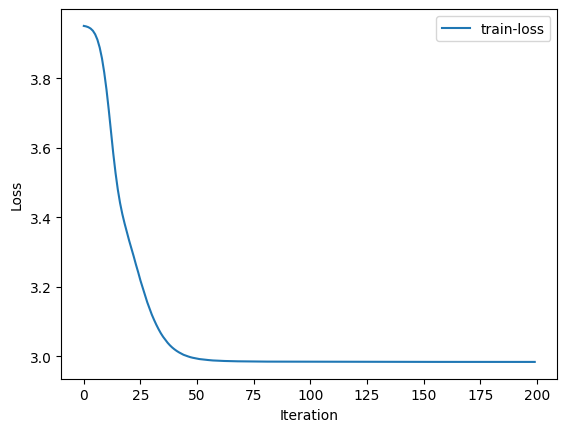

In [26]:
# TRAINING 
iter_loss = []
epoch_loss = []
best_acc = 0

with torch.no_grad():
    pass

patience = 10
prev_val_loss = 1e9 

for t in range(EPOCHS):
    tloss_train = train(GXy_train, train_idx, model, OPTIMIZER, SCHEDULER, LOSS_FN, 10)
    
    iter_loss = iter_loss + tloss_train  
    epoch_loss.append(sum(tloss_train) / len(tloss_train))
    
    val_loss, val_acc = test(GXy_train, val_idx, model, LOSS_FN)
    print(f'Epoch {t}: LOSS = {epoch_loss[-1]}, val-loss = {val_loss:.3f}, val-acc = {val_acc:.3f}')
    
    if val_loss >= prev_val_loss:
        patience -= 1
        if patience == 0:
            break
    
    else:
        patience = 10
        
    prev_val_loss = val_loss
    
torch.save(model.state_dict(), f'TextGCN_last.pth')
    
fig, axes = plt.subplots()
axes.plot(epoch_loss, label = 'train-loss')
axes.legend()
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.show()

In [ ]:
inputs = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
loss = LOSS_FN(inputs, target)
print(loss)

## Verify training accuracy

In [27]:
# GXy_train[0][0].to(CPU), GXy_train[1][0].to(CPU), GXy_train[2][0].to(CPU)
_, test_acc = test(GXy_train, train_idx, model, LOSS_FN)
print(f'Train accuracy: {test_acc}')

_, test_acc = test(GXy_train, val_idx, model, LOSS_FN)
print(f'Val accuracy: {test_acc}')

_, test_acc = test(GXy_train, test_idx, model, LOSS_FN)
print(f'Test accuracy: {test_acc}')

Train accuracy: 1.0
Val accuracy: 0.726078799249531
Test accuracy: 0.7272727272727273
